# Product Recognition on Store Shelves

### Marco Scaramuzzi 
- Student ID: 0001057167
- email: marco.scaramuzzi@studio.unibo.it

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:

1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).

#### Train on model image: {0.png, 1.png, 11.png, 19.png, 24.png, 25.png, 26.png}
#### Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}


In [173]:
#Import required modules
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from typing import Tuple
from collections import defaultdict
from glob import glob

# Only for jupyter notebook visualization
%matplotlib inline


from utils import * 
from image_loading import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading model image

In [174]:
file_to_model_mapping = {
    '0.jpg':'nes_ck_mlk',
    '1.jpg':'chc_krv_mlk',
    '11.jpg':'chc_krv_nuts',
    '19.jpg':'cnt_crs_nuts',   
    '24.jpg':'fit_pink',   
    '25.jpg':'pops_balls',   
    '26.jpg':'nes_duo',       
}

MODEL_NAME_TEST = '19.jpg'

model_file_names = ["0.jpg", "1.jpg", "11.jpg", "19.jpg", "24.jpg", "25.jpg", "26.jpg"]
model_files = {name: cv2.imread(f"models/{name}") for name in model_file_names}

# models_rgb, model_images = load_model_images(model_files)

# Caricamento immagini modello
# img_query = load_single_model(MODEL_NAME_TEST)
model_name = input('Insert model name: "0.jpg", "1.jpg", "11.jpg", "19.jpg", "24.jpg", "25.jpg", "26.jpg" ')
img_query = load_single_model(model_name)

## 1. Keypoints detection

SIFT object instantion

In [175]:
sift = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=10)  

Using SIFT to identify the keypoints and their descriptors of a single model

In [176]:
# Describing keypoints for query and train images
kp_query = sift.detect(img_query)

In [178]:
# show_images(models_rgb)

### Scene

Loading scene image

In [179]:
img_train = load_single_scene(scene_filename='m5', scene_dir="scenes/step_B/") # image m5.png

Using SIFT to identify the keypoints and their descriptors of a single scene

In [180]:
kp_train = sift.detect(img_train)

## 2. Keypoints description

### Feature Matching

In [181]:
# Describing keypoints for query and train images
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

In [182]:
print("Number of query descriptors: ", len(des_query))
print("Dimensionality of a SIFT descriptor: ", des_query[0].shape)
print("Type of the descriptor: ", des_query[0].dtype)

Number of query descriptors:  4528
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


## 3. Feature matching

In [183]:
# 🟢 1️⃣ Inizializzazione di FLANN
def initialize_flann():
    """
    Inizializza il matcher FLANN con parametri predefiniti.

    Returns:
        cv2.FlannBasedMatcher: Istanza di FLANN Matcher.
    """
    index_params = dict(algorithm=1, trees=5)  # FLANN_INDEX_KDTREE = 1
    search_params = dict(checks=50)
    return cv2.FlannBasedMatcher(index_params, search_params)

In [184]:
# Inizializzazione FLANN
flann = initialize_flann()
matches = flann.knnMatch(des_query,des_train,k=3)

## 4. Position Estimation 

In [185]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def compute_and_draw_homography_with_matches(
    img_query, img_train, kp_query, kp_train, good_matches, min_match_count=10):
    """
    Calcola omografia e visualizza i match buoni tra modello e scena, disegnando il bounding box.

    Ritorna:
        img_out (np.ndarray): Immagine combinata con match e bounding box.
        M (np.ndarray): Matrice omografia (o None).
        matchesMask (list): Maschera dei match validi usata per la visualizzazione.
    """

    if len(good_matches) > min_match_count:
        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h, w = img_query.shape[:2]
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        img_train_bb = cv2.polylines(img_train.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
        draw_params = dict(matchColor=(0,255,0),  # Verde per i match buoni
                           singlePointColor=None,
                           matchesMask=matchesMask,
                           flags=2)

        img_out = cv2.drawMatches(img_query, kp_query, img_train_bb, kp_train, good_matches, None, **draw_params)

        # Visualizza con matplotlib
        plt.figure(figsize=(14, 8))
        plt.imshow(img_out)
        plt.title('Match con bounding box')
        plt.axis('off')
        plt.show()

        return img_out, M, matchesMask

    else:
        print(f"Not enough matches are found - {len(good_matches)}/{min_match_count}")
        return None, None, None


In [186]:
# img_out, M, mask = compute_and_draw_homography_with_matches(
#     img_query, img_train, kp_query, kp_train, good
# )


In [187]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


def filter_false_positives_hybrid(matches: list, min_dist_threshold=250) -> list:
    """
    Filtra i falsi positivi combinando il criterio di Lowe classico e quello basato sulla media (k=3).
    
    Accetta un match solo se:
        - m1 è significativamente migliore di m2 (m1 < 0.7 * m2)
        - m1 è significativamente migliore della media tra m2 e m3
        - m1 non ha una distanza eccessiva (evita match deboli)

    Parametri:
        matches (list): Lista di triple (k=3) ottenute da knnMatch(..., k=3)
        min_dist_threshold (float): Distanza massima per considerare un match valido.

    Ritorna:
        good (list): Lista dei match accettati.
    """
    good = []
    for m in matches:
        if len(m) == 3:
            m1, m2, m3 = m
            avg_dist = (m2.distance + m3.distance) / 2.0
            
            if m1.distance < 0.7 * m2.distance and m1.distance < 0.75 * avg_dist and m1.distance < min_dist_threshold:
                good.append(m1)
    return good


# Define a function for object detection pipeline
def object_retrieve(img_query, img_train, min_match_count):
    sift = cv2.SIFT_create()
    plt.figure(figsize=(10,6))
    plt.imshow(img_query, cmap='gray', vmin= 0, vmax=255)

    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=3)
    # store all the good matches as per Lowe's ratio test.
    good = filter_false_positives_hybrid(matches)
    print(len(good))
    if len(good)>min_match_count:
        return len(good)
    else:
        return -1

In [188]:
# Trova tutti i file immagine nella cartella 'scenes/step_B'
from glob import glob
imgs_train = glob('scenes/step_A/*.png')


def compare_model_to_scenes(step='step_A', img_ext='.png'):
    imgs_train = glob(f'scenes/{step}/*{img_ext}')

    # Iterating among all images and looking for the query object.
    for path in imgs_train:
        img_train_bgr = cv2.imread(path)  # <-- immagine a colori in BGR
        img_train = cv2.cvtColor(img_train_bgr, cv2.COLOR_BGR2RGB)  # converti in RGB

        found = object_retrieve(img_query, img_train, min_match_count=70)
        print("Found query object in {}:{}".format(path,found > 0))
        if found > 0:
            plt.figure(figsize=(15,6))
            plt.imshow(img_train,   vmin= 0, vmax=255)
            plt.show()

70
Found query object in scenes/step_B\m1.png:False
107
Found query object in scenes/step_B\m2.png:True


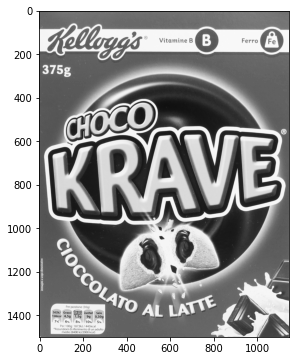

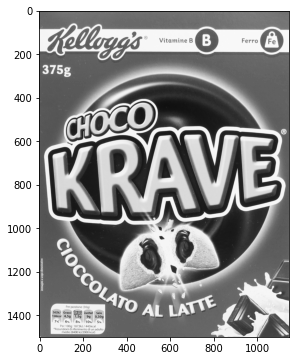

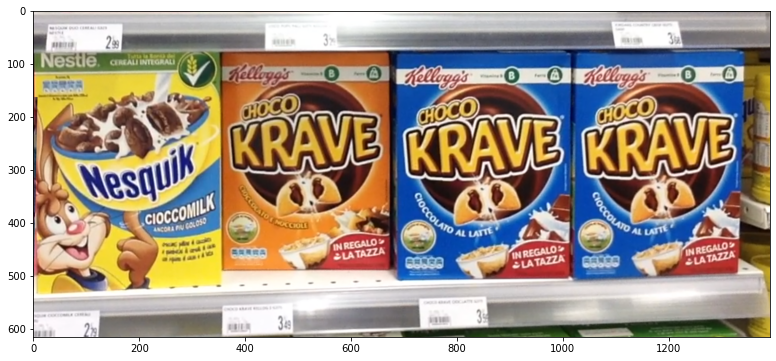

58
Found query object in scenes/step_B\m3.png:False
79
Found query object in scenes/step_B\m4.png:True


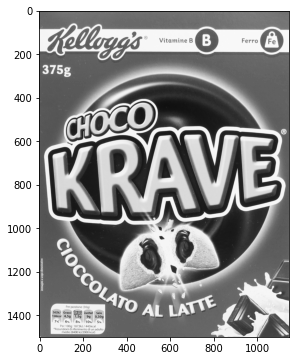

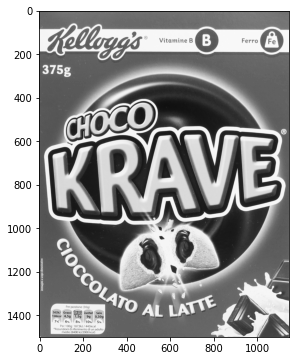

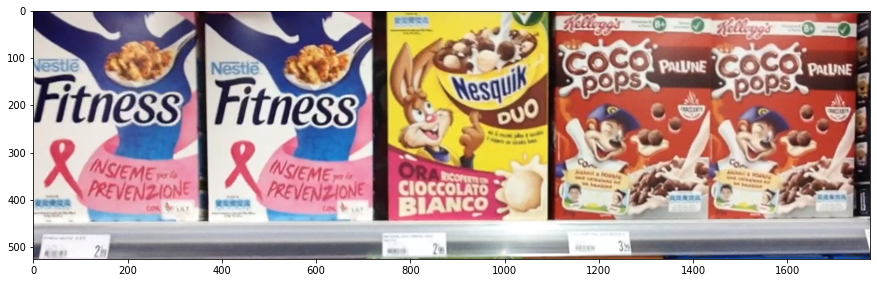

115
Found query object in scenes/step_B\m5.png:True


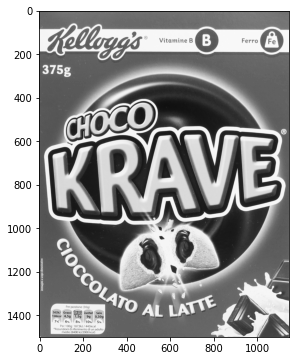

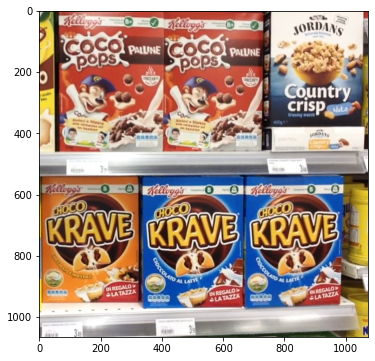

In [ ]:
compare_model_to_scenes(step='step_A')